# **Dự đoán cảm xúc bằng tiếng Anh**
![image.png](attachment:b8061be6-363f-492e-b797-1e87382c73be.png)

* **Người thực hiện:*
   - Đặng Văn Chiến - 3122410040
   - Nguyễn Anh Khoa - 312240185
   
   Mục tiêu của bài nghiên cứu này là tìm hiểu các lí thuyết cần thiết, để xây dựng được mô hình giải quyết bài toán nhận diện cảm xúc người dùng qua các ý kiến đánh giá, phản hồi ...qua đó mô hình sẽ được huấn luyện để nhận dạng và phân loại các cảm xúc cơ bản như:
- Buồn (Sadness)
- vui vẻ (Joy)
- Yêu ( Love )
- giận dữ (Anger )
- Bất ngờ ( Surprise )


Trong Chương trình này chúng em tập trung vào việc xây dựng các mô hình và hiệu suất của các mô hình, và từ đó có thể tìm ra mô hình có hiệu suất tốt nhất cho bài toán phân loại cảm xúc trong văn bản tiếng anh.

Các mô hình mà chúng em đề cập tới trong bài này là:
- **Linear SVC**
- **Logistic Regression**            
-***Naive Baye**

  **Một số ứng dụng của bài toán trên:***

  <h2 style="font-family: Arial, sans-serif; font-size: 24px;"><b> Các phần của dự chương trình 🗺️</b></h2>

**1.Khám phá dữ liệu**

**2.Tiền sử lý dữ liệu**

**3.Chia dữ liệu**

**4.Huấn luyện và điều chỉnh mô hình**

**5.Kết luận**

# Khám phá dữ liệu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import re

In [ ]:
import os
print(os.listdir())  # Liệt kê tất cả các tệp và thư mục trong thư mục hiện tại


['.config', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

mydata=pd.read_csv("/content/drive/MyDrive/Data/emotion.csv")
print(mydata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB
None


In [ ]:
mydata.shape

(416809, 3)

In [ ]:
mydata.columns = ['Index', 'Text', 'Label']  # Đặt tên cho các cột
mydata.head()

,Index,Text,Label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
#Thống kê các giá trị label
print(mydata['Label'].value_counts())
# 0 : saddness
# 1 : Joy
# 2 : Love
# 3 : anger
# 4 : fear
# 5 : surprise

Label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


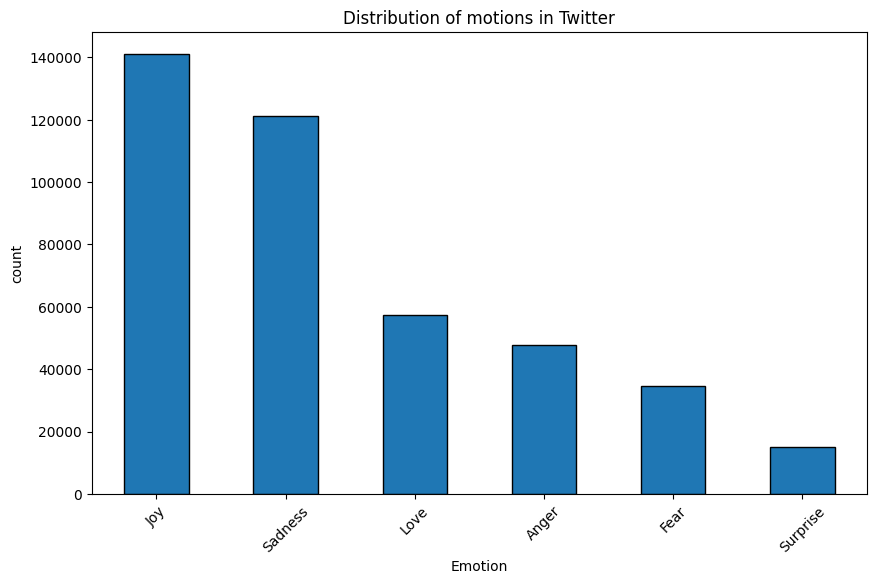

In [ ]:
plt.figure(figsize=(10,6))
label_counts = mydata['Label'].value_counts()
label_names = ['Joy','Sadness', 'Love', 'Anger', 'Fear', 'Surprise']
label_counts.index = label_names
label_counts.plot(kind = 'bar', edgecolor='black')
plt.title('Distribution of motions in Twitter')
plt.xlabel('Emotion')
plt.ylabel('count')
plt.xticks(rotation =45)
plt.show()

<ipython-input-27-544a017a5fe2>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)


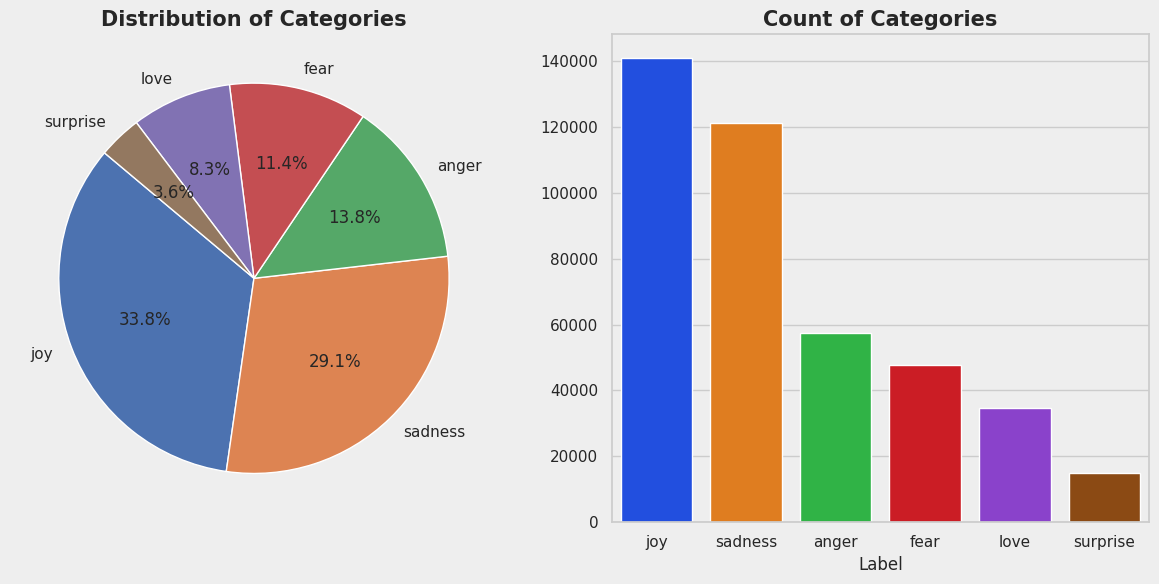

In [ ]:
# Tạo dictionary mapping số thành chữ
label_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Ánh xạ giá trị số sang chữ, nhưng chỉ sử dụng tạm thời
labels_for_plot = mydata['Label'].map(label_mapping)

# Đếm tần số các nhãn sau khi ánh xạ
count = labels_for_plot.value_counts()

#cài đặt background
background_color = '#eeeeee'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
mydata.describe()

,Index,Label
count,416809.000000,416809.000000
mean,208404.000000,1.554271
std,120322.538513,1.490453
min,0.000000,0.000000
25%,104202.000000,0.000000
50%,208404.000000,1.000000
75%,312606.000000,3.000000
max,416808.000000,5.000000


**Một số từ thường gặp trong cảm xúc Buồn**




# Tiền sử lý dữ liệu

## Kiểm tra dữ liệu trùm lặp

In [ ]:
print(f"Có dữ dự trùm lặp nào không : {mydata.duplicated().values.any()}\n")

Có dữ dự trùm lặp nào không : False



## Kiểm tra dữ liệu thiếu ( Nan Values )

In [ ]:
valuesnull = mydata.isnull().sum()
print(valuesnull)

Index    0
Text     0
Label    0
dtype: int64


### xóa urls

In [ ]:
# bước 1: xóa URLs
mydata['Text'] = mydata['Text'].str.replace(r'http\S+', '', regex=True)
print(mydata.head())

   Index                                               Text  Label
0      0      i just feel really helpless and heavy hearted      4
1      1  ive enjoyed being able to slouch about relax a...      0
2      2  i gave up my internship with the dmrg and am f...      4
3      3                         i dont know i feel so lost      0
4      4  i am a kindergarten teacher and i am thoroughl...      4


### Xóa các ký hiệu đặc biệt và dấu câu

In [ ]:
mydata['Text'] = mydata['Text'].str.replace(r'[^\w\s]', '', regex=True)

print(mydata.head())

   Index                                               Text  Label
0      0      i just feel really helpless and heavy hearted      4
1      1  ive enjoyed being able to slouch about relax a...      0
2      2  i gave up my internship with the dmrg and am f...      4
3      3                         i dont know i feel so lost      0
4      4  i am a kindergarten teacher and i am thoroughl...      4


### Xóa khoảng trắng dư thừa

In [ ]:
mydata['Text'] = mydata['Text'].str.replace(r'\s+', ' ', regex=True)

print(mydata.head())

   Index                                               Text  Label
0      0      i just feel really helpless and heavy hearted      4
1      1  ive enjoyed being able to slouch about relax a...      0
2      2  i gave up my internship with the dmrg and am f...      4
3      3                         i dont know i feel so lost      0
4      4  i am a kindergarten teacher and i am thoroughl...      4


### Xóa các giá trị số trong văn bản

In [ ]:
mydata['Text'] = mydata['Text'].str.replace(r'\d+', '', regex=True)

mydata.head()

,Index,Text,Label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


### Chuyển thành văn bản chữ thường

In [ ]:

mydata['Text'] = mydata['Text'].str.lower()

print(mydata.head())

   Index                                               Text  Label
0      0      i just feel really helpless and heavy hearted      4
1      1  ive enjoyed being able to slouch about relax a...      0
2      2  i gave up my internship with the dmrg and am f...      4
3      3                         i dont know i feel so lost      0
4      4  i am a kindergarten teacher and i am thoroughl...      4


### Xóa các stop words

In [ ]:
#import các thư viện
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#tải  dữ liệu
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = stopwords.words('english')
mydata["Text"] = mydata['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
mydata.head()

,Index,Text,Label
0,0,feel really helpless heavy hearted,4
1,1,ive enjoyed able slouch relax unwind frankly n...,0
2,2,gave internship dmrg feeling distraught,4
3,3,dont know feel lost,0
4,4,kindergarten teacher thoroughly weary job take...,4


## Xóa các ký tự không phải chữ hoặc số

In [ ]:
mydata['Text'] = mydata['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

mydata.head()

,Index,Text,Label
0,0,feel really helpless heavy hearted,4
1,1,ive enjoyed able slouch relax unwind frankly n...,0
2,2,gave internship dmrg feeling distraught,4
3,3,dont know feel lost,0
4,4,kindergarten teacher thoroughly weary job take...,4


### Một số từ thường gặp trong với các cảm xúc

In [ ]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

<ipython-input-18-e8c9ff06b2c4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(


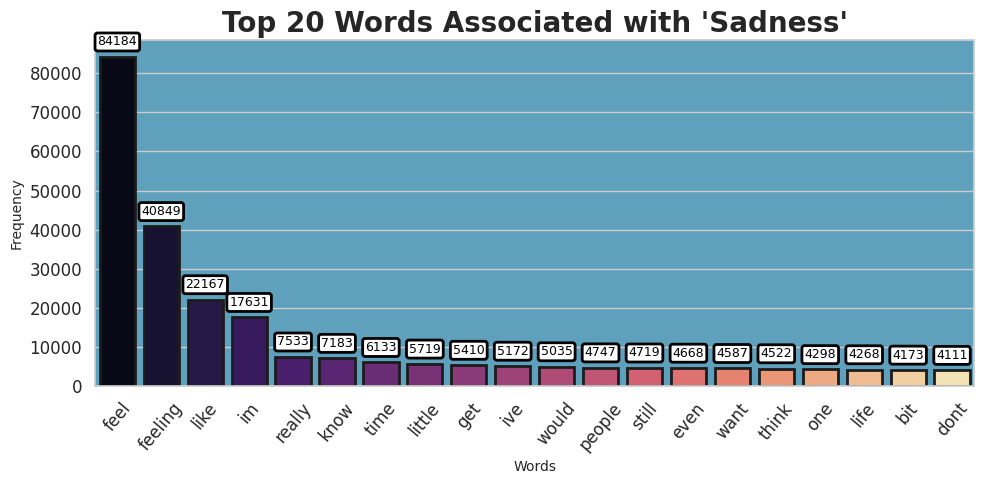

In [ ]:
# Lọc các văn bản có cảm xúc 'Sadness' (Label = 0)
love_texts = mydata[mydata['Label'] == 0]['Text']

# Tokenize các văn bản và đếm tần suất của từng từ
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Lấy 20 từ phổ biến nhất
top_20_words = dict(word_freq.most_common(20))

# Tùy chỉnh giao diện và màu sắc
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
p = sns.barplot(
    x=list(top_20_words.keys()),
    y=list(top_20_words.values()),
    palette='magma',
    edgecolor='#1c1c1c',
    linewidth=2,
    legend=False

)
for container in p.containers:
    plt.bar_label(
        container,
        label_type="edge",
        color="black",
        fontsize=9,
        padding=6,
        bbox={
            "boxstyle": "round",
            "pad": 0.2,
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 2,
            "alpha": 1
        }
    )

# Tùy chỉnh biểu đồ
plt.title("Top 20 Words Associated with 'Sadness'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=50, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-19-e707f6984cd0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(


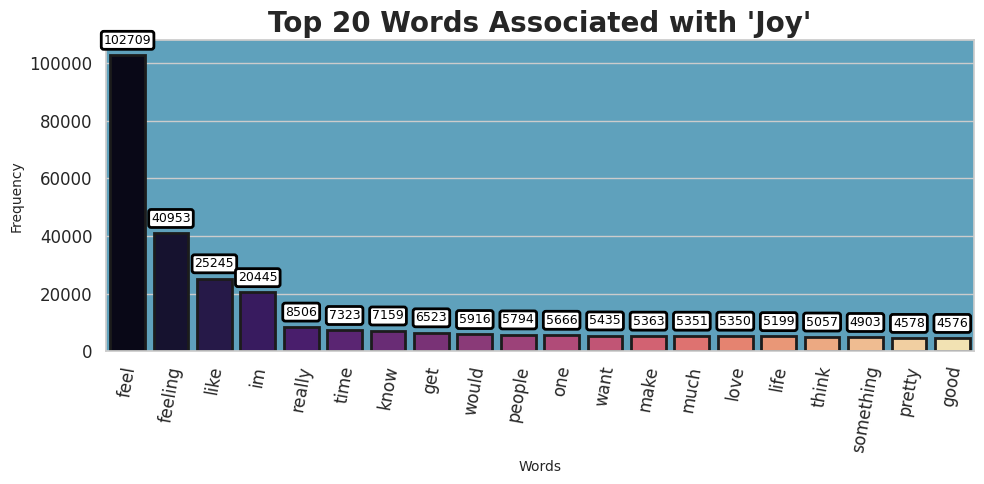

In [ ]:

# Lọc các văn bản có cảm xúc 'Joy' (Label = 1)
love_texts = mydata[mydata['Label'] == 1]['Text']

# Tokenize các văn bản và đếm tần suất của từng từ
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Lấy 20 từ phổ biến nhất
top_20_words = dict(word_freq.most_common(20))

# Tùy chỉnh giao diện và màu sắc
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
p = sns.barplot(
    x=list(top_20_words.keys()),
    y=list(top_20_words.values()),
    palette='magma',
    edgecolor='#1c1c1c',
    linewidth=2,
    legend=False

)
for container in p.containers:
    plt.bar_label(
        container,
        label_type="edge",
        color="black",
        fontsize=9,
        padding=6,
        bbox={
            "boxstyle": "round",
            "pad": 0.2,
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 2,
            "alpha": 1
        }
    )

# Tùy chỉnh biểu đồ
plt.title("Top 20 Words Associated with 'Joy'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-20-6e82e8d01d43>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(


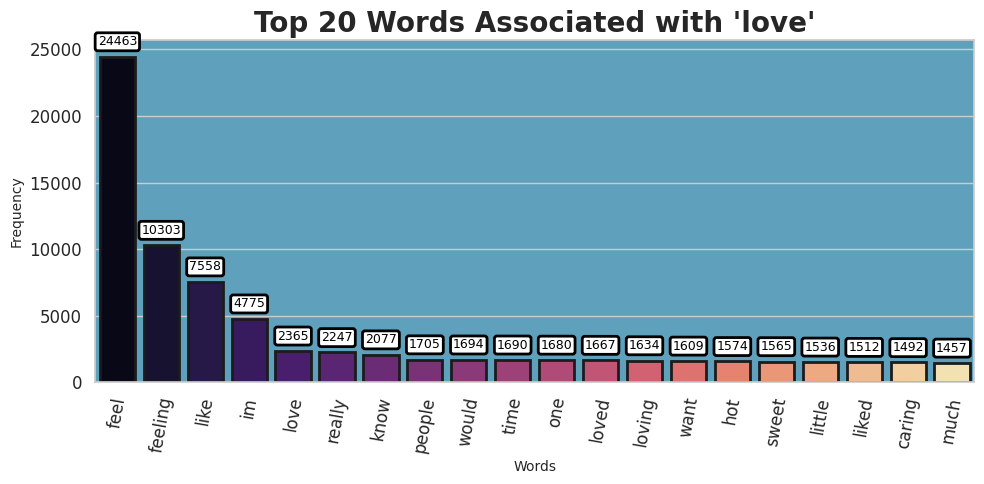

In [ ]:

# Lọc các văn bản có cảm xúc 'love' (Label = 2)
love_texts = mydata[mydata['Label'] == 2]['Text']

# Tokenize các văn bản và đếm tần suất của từng từ
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Lấy 20 từ phổ biến nhất
top_20_words = dict(word_freq.most_common(20))

# Tùy chỉnh giao diện và màu sắc
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
p = sns.barplot(
    x=list(top_20_words.keys()),
    y=list(top_20_words.values()),
    palette='magma',
    edgecolor='#1c1c1c',
    linewidth=2,
    legend=False

)
for container in p.containers:
    plt.bar_label(
        container,
        label_type="edge",
        color="black",
        fontsize=9,
        padding=6,
        bbox={
            "boxstyle": "round",
            "pad": 0.2,
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 2,
            "alpha": 1
        }
    )

# Tùy chỉnh biểu đồ
plt.title("Top 20 Words Associated with 'love'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-21-d86983261599>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(


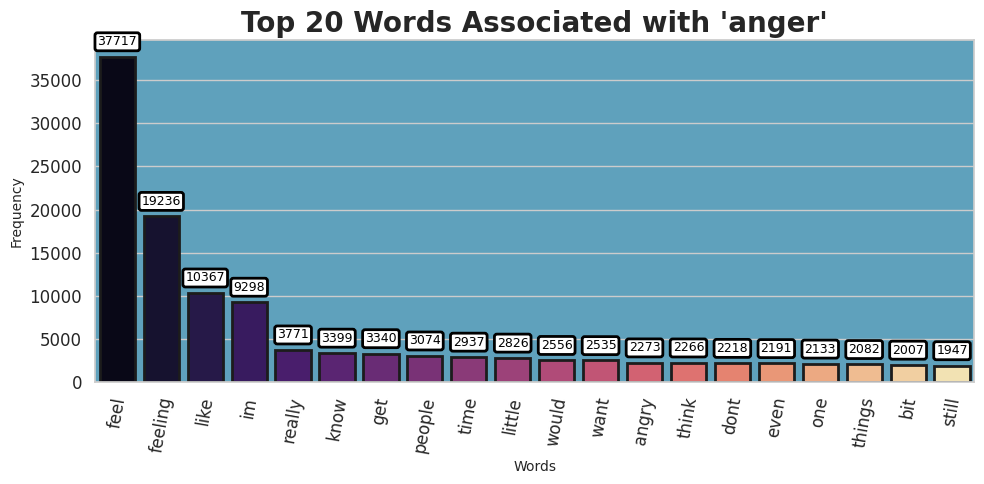

In [ ]:

# Lọc các văn bản có cảm xúc 'anger' (Label = 3)
love_texts = mydata[mydata['Label'] == 3]['Text']

# Tokenize các văn bản và đếm tần suất của từng từ
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Lấy 20 từ phổ biến nhất
top_20_words = dict(word_freq.most_common(20))

# Tùy chỉnh giao diện và màu sắc
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
p = sns.barplot(
    x=list(top_20_words.keys()),
    y=list(top_20_words.values()),
    palette='magma',
    edgecolor='#1c1c1c',
    linewidth=2,
    legend=False

)
for container in p.containers:
    plt.bar_label(
        container,
        label_type="edge",
        color="black",
        fontsize=9,
        padding=6,
        bbox={
            "boxstyle": "round",
            "pad": 0.2,
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 2,
            "alpha": 1
        }
    )

# Tùy chỉnh biểu đồ
plt.title("Top 20 Words Associated with 'anger'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-68-e779869bee81>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(


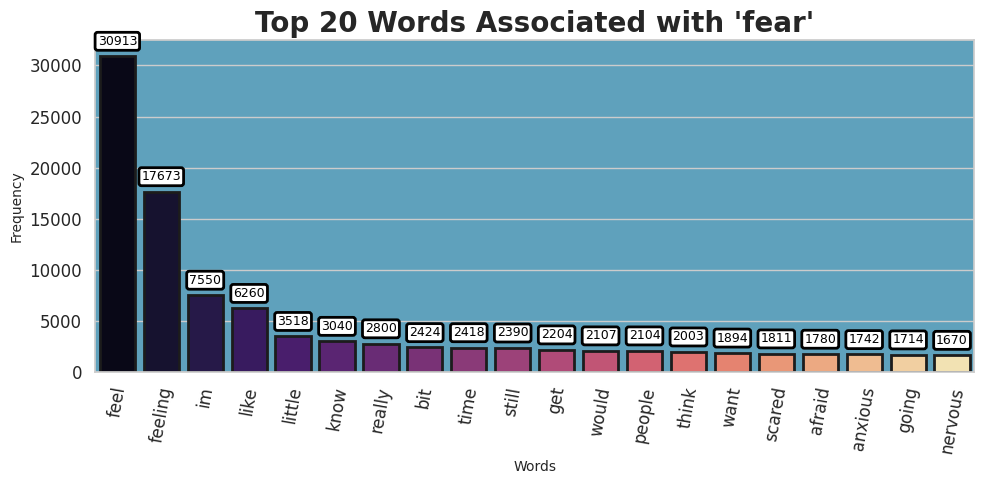

In [ ]:
# Lọc các văn bản có cảm xúc 'fear' (Label = 4)
love_texts = mydata[mydata['Label'] == 4]['Text']

# Tokenize các văn bản và đếm tần suất của từng từ
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Lấy 20 từ phổ biến nhất
top_20_words = dict(word_freq.most_common(20))

# Tùy chỉnh giao diện và màu sắc
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
p = sns.barplot(
    x=list(top_20_words.keys()),
    y=list(top_20_words.values()),
    palette='magma',
    edgecolor='#1c1c1c',
    linewidth=2,
    legend=False

)
for container in p.containers:
    plt.bar_label(
        container,
        label_type="edge",
        color="black",
        fontsize=9,
        padding=6,
        bbox={
            "boxstyle": "round",
            "pad": 0.2,
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 2,
            "alpha": 1
        }
    )

# Tùy chỉnh biểu đồ
plt.title("Top 20 Words Associated with 'fear'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-70-9c48aa23eeac>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(


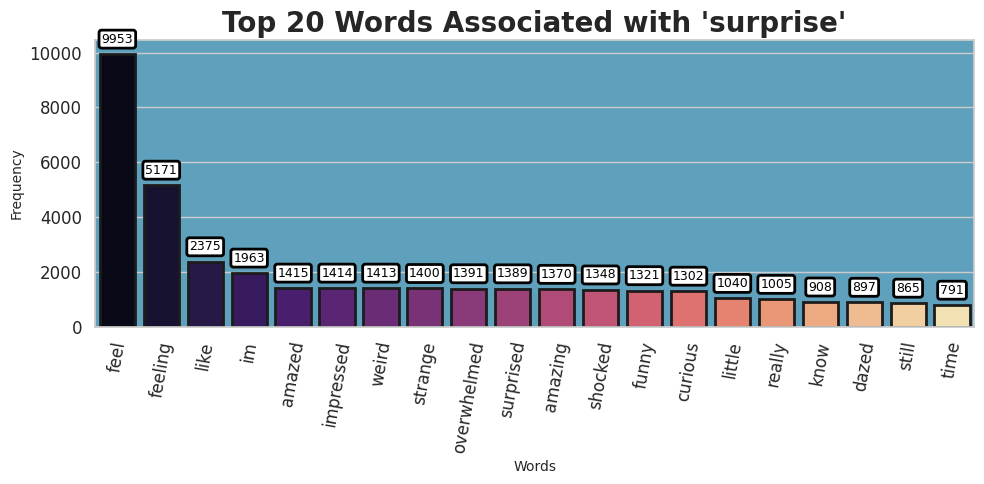

In [ ]:
# Lọc các văn bản có cảm xúc 'surprise' (Label = 5)
love_texts = mydata[mydata['Label'] == 5]['Text']

# Tokenize các văn bản và đếm tần suất của từng từ
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Lấy 20 từ phổ biến nhất
top_20_words = dict(word_freq.most_common(20))

# Tùy chỉnh giao diện và màu sắc
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
p = sns.barplot(
    x=list(top_20_words.keys()),
    y=list(top_20_words.values()),
    palette='magma',
    edgecolor='#1c1c1c',
    linewidth=2,
    legend=False

)
for container in p.containers:
    plt.bar_label(
        container,
        label_type="edge",
        color="black",
        fontsize=9,
        padding=6,
        bbox={
            "boxstyle": "round",
            "pad": 0.2,
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 2,
            "alpha": 1
        }
    )

# Tùy chỉnh biểu đồ
plt.title("Top 20 Words Associated with 'surprise'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Xây dụng mô hình

### Chia dữ liệu

In [ ]:
from sklearn.model_selection import train_test_split
    # chia dữ liệu cho training  (80 %) và testing sets (20 % ) theo từng nhãn
X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)

In [ ]:
# prompt: kích thước của tập train và tập test sau khi chia dữ liệu
print(f"Training set size: {X_train.shape} : {y_train.shape}")
print(f"Testing set size: {X_test.shape} : {y_test.shape}")

Training set size: (333447,) : (333447,)
Testing set size: (83362,) : (83362,)


**F1-score được sử dụng để đánh giá mô hình trong bài toán này vì những lý do sau:**

**Cân bằng giữa Precision và Recall:** F1-score là trung bình điều hòa của Precision và Recall. Precision đo lường tỷ lệ dự đoán đúng trong số các dự đoán tích cực, trong khi Recall đo lường tỷ lệ dự đoán đúng trong số các trường hợp thực sự tích cực. F1-score cân bằng giữa hai số liệu này, giúp đánh giá hiệu suất tổng thể của mô hình một cách toàn diện hơn.

**Phù hợp với bài toán phân loại:** F1-score là số liệu thường được sử dụng để đánh giá hiệu suất của mô hình phân loại, đặc biệt là khi các lớp phân bố không đều. Trong bài toán này, các cảm xúc có thể có tần suất xuất hiện khác nhau, F1-score giúp đảm bảo rằng mô hình được đánh giá công bằng trên tất cả các lớp.

**Dễ hiểu và diễn giải:** F1-score là một số liệu dễ hiểu và diễn giải, giúp dễ dàng so sánh hiệu suất của các mô hình khác nhau.

## Mô hình 1 - Linear Suport Vector Classifier ( SVC )

Trươc khi luấn luyện mô hình chúng ta cần chuyển đổi văn bản thành các vector số để máy học có thể sử dụng. trong trường hợp này chúng em sử dụng kỹ thuật TF-IDF.

Đầu tiên, chúng em quyết định sử dụng phương pháp Linear Support Vector Classifier (LinearSVC), đây là một biến thể của Support Vector Machines (SVM).được thiết kế để giải quyết các bài toán phân loại tuyến tính hiệu quả. LinearSVC là một triển khai tối ưu hóa của SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # thư viện dùng để chuẩn hóa vector cho dữ liệu
from sklearn.metrics import classification_report # thư viện dùng để đánh giá mô hình

import pickle #Thư viện pickle để lưu mô hình

In [ ]:
#hàm báo cáo đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    # dự đoán cảm xúc cho tập test
    y_pred = model.predict(X_test)
    # Display the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import LinearSVC

def linear_SVC_train():  #tạo mô hình
     # chia dữ liệu cho training  (80 %) và testing sets (20 % ) theo từng nhãn
    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)

    # chuẩn hóa vector số học cho văn bản bằng TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000) #chỉ sử dụng 1000 từ quan trọng nhất làm đặc trưng
    X_train_vectorized = vectorizer.fit_transform(X_train) #  fit_transform(): áp dụng TF-IDF cho tập tranning
    X_test_vectorized = vectorizer.transform(X_test) # Vectorizer: sử dụng Vectorizer đã huấn luyện để biến đổi tập testing

    # Cài đặt các thăm số mặc định cho mô hình
    model_params = {
        'C': 1.0,
        'loss': 'squared_hinge',
        'max_iter': 1000,
        'penalty': 'l2',
        'dual': True,
        'tol': 1e-4
    }

    # khởi tạo và trainning mô hình
    model = LinearSVC(**model_params)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

#hàm báo cáo đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    # dự đoán cảm xúc cho tập test
    y_pred = model.predict(X_test)
    # Display the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Gọi hàm huấn luyện mô hình
model_svc, trained_vectorizer, X_test, y_test = linear_SVC_train()

# Gọi hàm báo cáo đánh giá mô hình vừa tạo
evaluate_model(model_svc, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     24238
           1       0.84      0.93      0.88     28214
           2       0.81      0.74      0.77      6911
           3       0.88      0.82      0.85     11463
           4       0.85      0.78      0.82      9542
           5       0.78      0.74      0.76      2994

    accuracy                           0.87     83362
   macro avg       0.85      0.82      0.83     83362
weighted avg       0.87      0.87      0.87     83362



Trong kết quả của chúng em, chúng em tập trung vào điểm F1 như một số liệu chính. Điểm F1 là phép đo kết hợp giữa độ chính xác (precision ) và độ thu hồi(f1-score), cung cấp đánh giá cân bằng về hiệu suất của mô hình, đặc biệt là khi các lớp phân bố không đều. Với Mô hình 1 của chúng em, mô hình đã đạt được điểm F1 tổng thể là 0,82.

### Điểm F1-score thấp hơn so với kỳ vọng nên chúng em quyết định cải thiện hiệu suất thông qua các tham số

Phương pháp cải thiện 👨‍🏫

**1. Vector hóa TF-IDF:**
* Tăng số lượng đặc trưng trong vector TF-IDF từ **1000** lên **5000** để nắm bắt nhiều thông tin chi tiết hơn từ dữ liệu văn bản.

**2. Điều chỉnh siêu tham số của mô hình:**

* Tham số điều chuẩn (C): Giảm từ **1.0** xuống **0.1** để giảm overfitting và cải thiện khả năng tổng quát hóa của mô hình.
* Hàm mất mát: Thay đổi từ '**squared_hinge**' sang '**hinge**' để đạt hiệu suất tốt hơn.
* Số lần lặp tối đa: Tăng từ 1000 lên **5000** để cho phép mô hình hội tụ đến giải pháp tốt hơn.
* Chuẩn hóa: Giữ nguyên **L2** để thực hiện điều chuẩn.
* Dual: Giữ nguyên True để giải bài toán tối ưu hóa.


In [ ]:
def linear_SVC_train():
     # chia dữ liệu cho training  (80 %) và testing sets (20 % )
    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)

    # Vectorize the text data
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    # Set the model parameters
    model_params = {
        'C': 0.1,
        'loss': 'hinge',
        'max_iter': 5000,
        'penalty': 'l2',
        'dual': True,
        'tol': 1e-4
    }

    # Khởi tạo và training mô hình
    model = LinearSVC(**model_params)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test


# Gọi hàm để training mô hình
model_svc, trained_vectorizer, X_test, y_test = linear_SVC_train()

# Gọi hàm đánh gia mô hình
evaluate_model(model_svc, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     24238
           1       0.90      0.96      0.93     28214
           2       0.90      0.70      0.79      6911
           3       0.91      0.90      0.90     11463
           4       0.86      0.86      0.86      9542
           5       0.90      0.64      0.75      2994

    accuracy                           0.90     83362
   macro avg       0.90      0.83      0.86     83362
weighted avg       0.90      0.90      0.90     83362



### Kết Quả Điều Chỉnh
Sau khi điều chỉnh lại các tham số điểm F1-sscore tổng thể của mô hình từ **0.82** đã tăng lên **0.86**

In [ ]:
#Lưu mô hình
model_pkl_file = "emotion_md_SVC.pkl"
with open(model_pkl_file, 'wb') as file:
      pickle.dump(model_svc, file)

## Mô hình thứ 2 - Logistic Regression ⚙️

In [ ]:
from sklearn.linear_model import LogisticRegression
def logistic_regression_classifier():
    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)

    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    # Các tham số mặc định của hàm mô hình
    model_params = {
        'C': 0.1,
        'penalty': 'l2',
        'max_iter': 5000,
        'solver': 'saga',
        'random_state': 1
    }

    model = LogisticRegression(**model_params)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

model_lr, trained_vectorizer, X_test, y_test = logistic_regression_classifier()
evaluate_model(model_lr, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     24238
           1       0.83      0.94      0.88     28214
           2       0.84      0.70      0.76      6911
           3       0.90      0.80      0.84     11463
           4       0.85      0.79      0.82      9542
           5       0.83      0.69      0.75      2994

    accuracy                           0.86     83362
   macro avg       0.86      0.80      0.83     83362
weighted avg       0.87      0.86      0.86     83362



**Hiệu suất của mô hình:**
Điểm F1-Score của mô hình thứ 2 đặt được là **0.83** , một điểm số trung bình nên chúng em quyết định cải thiện mô xem có tốt hơn không.

**Phương pháp cải thiện :**

**1. Vector hóa TF-IDF:**
* Tăng số lượng đặc trưng trong vector TF-IDF từ 1000 lên **5000**.

**2. Điều chỉnh siêu tham số của mô hình:**
* Hình phạt điều chuẩn: Thay đổi từ **L2** sang **L1** để tạo sự thưa thớt (sparsity) và có khả năng cải thiện việc lựa chọn đặc trưng bằng cách giảm ảnh hưởng của các đặc trưng kém quan trọng.
* Số lần lặp tối đa: Tăng từ **5000** lên **10000** để cho phép thời gian hội tụ lâu hơn, giúp tối ưu hóa tốt hơn các tham số của mô hình.

In [ ]:

def logistic_regression_classifier():
    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    model_params = {
        'C': 0.1,
        'penalty': 'l1',
        'max_iter': 10000,
        'solver': 'saga',
        'random_state': 1
     }
    model = LogisticRegression(**model_params)
    model.fit(X_train_vectorized, y_train)
    return model, vectorizer, X_test_vectorized, y_test

model_lr, trained_vectorizer, X_test, y_test = logistic_regression_classifier()
evaluate_model(model_lr, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     24201
           1       0.91      0.94      0.93     28164
           2       0.84      0.78      0.81      6929
           3       0.91      0.91      0.91     11441
           4       0.87      0.86      0.86      9594
           5       0.83      0.72      0.77      3033

    accuracy                           0.91     83362
   macro avg       0.88      0.86      0.87     83362
weighted avg       0.91      0.91      0.91     83362



### Kết Quả Điều Chình
* Những điều chỉnh này đã tác động đáng kể đến F1-score, minh chứng sự cải thiện vượt bậc trong hiệu suất.
* F1-score ban đầu khoảng **0.81** đã được nâng lên **0.87!** 🥳

In [ ]:
#Lưu mô hình để sử dụng
model_pkl_file = "emotion_md_LR.pkl"
with open(model_pkl_file, 'wb') as file:
        pickle.dump(model_lr, file)

## Mô hình 3 - Naive Bayes Classifier

Cuối cùng. mô hình thứ 3 là Naive Bayes Classifier. Đây là một phương pháp thường được sử dụng trong phân tích và phân loại văn bản nhờ khả năng xử lý tốt các nhiệm vụ liên quan đến văn bản. Một đặc điểm quan trọng của Naive Bayes là giả định các đặc trưng độc lập với nhau, tức là nó xem xét xác suất xảy ra của từng đặc trưng một cách riêng lẻ. Điều này khiến Naive Bayes trở thành lựa chọn phổ biến trong phân tích văn bản trong lĩnh vực khoa học dữ liệu.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
def naive_bayes_classifier():
    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

model_mnb, trained_vectorizer, X_test, y_test = naive_bayes_classifier()
evaluate_model(model_mnb, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     24201
           1       0.80      0.97      0.88     28164
           2       0.95      0.49      0.64      6929
           3       0.94      0.79      0.86     11441
           4       0.89      0.73      0.80      9594
           5       0.97      0.31      0.47      3033

    accuracy                           0.85     83362
   macro avg       0.90      0.71      0.76     83362
weighted avg       0.86      0.85      0.84     83362



**Hiệu suất mô hình:** Điểm số F1_score của mô VB khá là thấp chỉ được **0.72**.

**Điều chỉnh Mô hình 3 📈**

Trong phiên bản cải thiện của mô hình phân loại Naive Bayes, các siêu tham số đã được điều chỉnh nhằm cải thiện hiệu suất.

Phương pháp tiếp cận 👨‍✈️

 **Tuning Siêu tham số của mô hình:**
* Force Alpha: Tắt tính năng này (force_alpha được đặt thành False) để ngăn việc làm mịn tự động.
* Giá trị Alpha: Đặt bằng 0, không sử dụng làm mịn Laplace, nhằm tránh hiện tượng overfitting có thể xảy ra với việc làm mịn tự động.
* Fit Prior: Đặt thành False để tắt tính năng khớp xác suất tiên nghiệm của các lớp, cung cấp sự linh hoạt hơn trong việc xử lý phân phối lớp không cân bằng.

In [ ]:
def naive_bayes_classifier():
    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    model = MultinomialNB(force_alpha=False, alpha=0, fit_prior=False)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

model_mnb, trained_vectorizer, X_test, y_test = naive_bayes_classifier()
evaluate_model(model_mnb, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     24201
           1       0.95      0.85      0.90     28164
           2       0.67      0.91      0.77      6929
           3       0.88      0.90      0.89     11441
           4       0.83      0.85      0.84      9594
           5       0.60      0.87      0.71      3033

    accuracy                           0.88     83362
   macro avg       0.81      0.88      0.84     83362
weighted avg       0.89      0.88      0.88     83362



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:620: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


### Kết quả điều chỉnh
Những thay đổ trên đã mang lại những cải thiện đáng kể cho mô hình và điểm F1-score từ **0.72** đến **0.83**

In [ ]:
#lưu mô hình
model_pkl_file = "emotion_md_MNB.pkl"
with open(model_pkl_file, 'wb') as file:

        pickle.dump(model_mnb, file)

## Mô hình thứ 4 - RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_classifier():

    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    model = RandomForestClassifier(n_estimators=10, random_state=42)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

trained_model, trained_vectorizer, X_test, y_test = random_forest_classifier()
evaluate_model(trained_model, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     24238
           1       0.84      0.86      0.85     28214
           2       0.66      0.65      0.66      6911
           3       0.81      0.81      0.81     11463
           4       0.76      0.74      0.75      9542
           5       0.63      0.66      0.64      2994

    accuracy                           0.82     83362
   macro avg       0.77      0.77      0.77     83362
weighted avg       0.82      0.82      0.82     83362



In [ ]:
def random_forest_classifier():

    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    model = RandomForestClassifier(n_estimators=10, min_samples_leaf=4 ,random_state=42)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

trained_model, trained_vectorizer, X_test, y_test = random_forest_classifier()
evaluate_model(trained_model, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     24238
           1       0.91      0.90      0.91     28214
           2       0.78      0.72      0.75      6911
           3       0.86      0.90      0.88     11463
           4       0.81      0.84      0.82      9542
           5       0.71      0.69      0.70      2994

    accuracy                           0.88     83362
   macro avg       0.83      0.83      0.83     83362
weighted avg       0.88      0.88      0.88     83362



In [ ]:
def random_forest_classifier():

    X_train, X_test, y_train, y_test = train_test_split(mydata['Text'], mydata['Label'], test_size=0.2, stratify=mydata['Label'], random_state=42)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    model = RandomForestClassifier(n_estimators=20, min_samples_leaf=4 ,random_state=42)
    model.fit(X_train_vectorized, y_train)

    return model, vectorizer, X_test_vectorized, y_test

trained_model, trained_vectorizer, X_test, y_test = random_forest_classifier()
evaluate_model(trained_model, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     24238
           1       0.92      0.90      0.91     28214
           2       0.78      0.71      0.74      6911
           3       0.86      0.90      0.88     11463
           4       0.80      0.83      0.82      9542
           5       0.71      0.68      0.69      2994

    accuracy                           0.88     83362
   macro avg       0.83      0.82      0.83     83362
weighted avg       0.88      0.88      0.88     83362



**Biểu đồ trực quan hóa các mô hình**

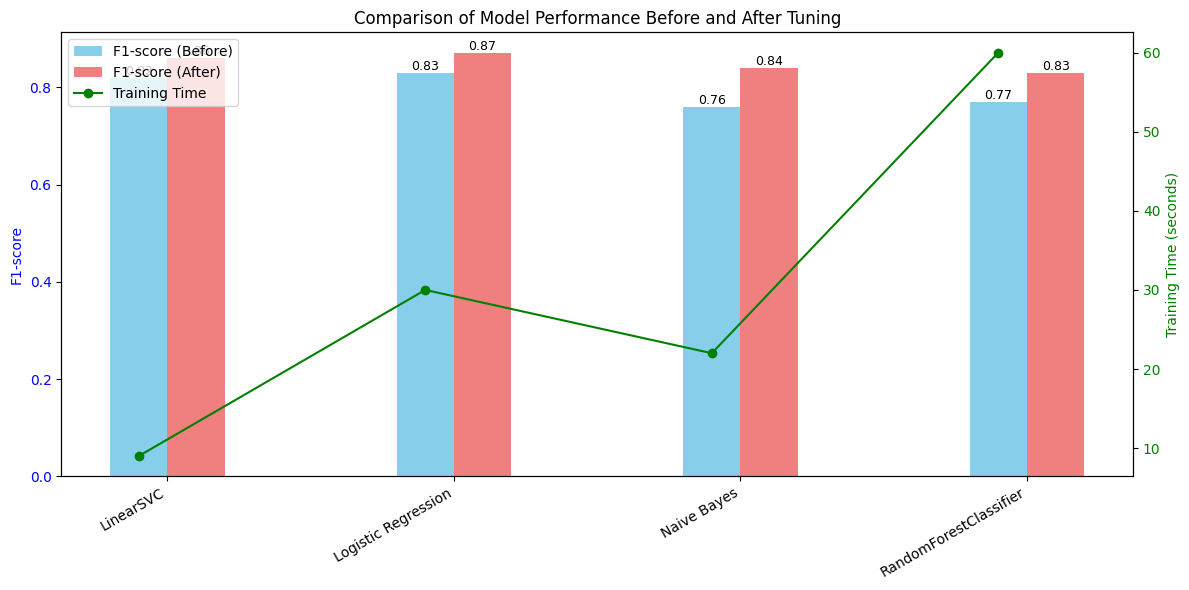

In [ ]:
# prompt: tạo biểu đồ so sánh kết quả điểm f1-score trước và sau khi tinh chỉnh  của các thuật toán và co· thời gian chạy của mỗi lần

import matplotlib.pyplot as plt

# Sample data (replace with your actual results)
models = ['LinearSVC', 'Logistic Regression', 'Naive Bayes', 'RandomForestClassifier']
f1_scores_before = [0.82, 0.83, 0.76, 0.77]
f1_scores_after = [0.86, 0.87, 0.84, 0.83]
training_times = [9, 30, 22, 60]  # Example times, replace with your actual times


x = range(len(models))
width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))

# F1-score bars
rects1 = ax1.bar(x, f1_scores_before, width, label='F1-score (Before)', color='skyblue')
rects2 = ax1.bar([i + width for i in x], f1_scores_after, width, label='F1-score (After)', color='lightcoral')
ax1.set_ylabel('F1-score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(models, rotation=30, ha='right')

# Training time line
ax2 = ax1.twinx()
ax2.plot(x, training_times, marker='o', linestyle='-', color='green', label='Training Time')
ax2.set_ylabel('Training Time (seconds)', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# Add labels to the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width() / 2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

add_labels(rects1)
add_labels(rects2)


# Add a title and legend
plt.title('Comparison of Model Performance Before and After Tuning')
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)


plt.tight_layout()
plt.show()

# Kết Luận

## Hiệu Suất Mô Hình
Mô hình hồi quy logistic, sau khi tinh chỉnh các siêu tham số và áp dụng kỹ thuật vector hóa, đã trở thành mô hình có hiệu suất tốt nhất trong số các mô hình được thử nghiệm. Mô hình này đạt được F1-score ấn tượng là 0.87, vượt qua cả máy vector hỗ trợ (SVM) và bộ phân loại Naive Bayes, Random forest

## Tinh Chỉnh Siêu Tham Số
Việc điều chỉnh các siêu tham số đóng vai trò quan trọng trong việc cải thiện hiệu suất. Các thay đổi như điều chỉnh tham số điều chuẩn, lựa chọn hàm mất mát phù hợp, và tăng số lần lặp đã giúp mô hình phân loại cảm xúc chính xác hơn.

## Kỹ Thuật Xử Lý Đặc Trưng
Việc sử dụng TF-IDF với số lượng đặc trưng tăng từ 1000 lên 5000 đã mang lại biểu diễn phong phú hơn cho dữ liệu văn bản, từ đó cải thiện kết quả phân loại của các mô hình.

## Khả Năng Diễn Giải Mô Hình
Ngoài hiệu suất vượt trội, mô hình hồi quy logistic còn mang lại khả năng diễn giải, giúp hiểu rõ hơn các yếu tố ảnh hưởng đến dự đoán của nó. Điều này rất hữu ích trong các ứng dụng thực tế, nơi tính minh bạch và khả năng giải thích là rất quan trọng.

## Hướng Cải Thiện Tiếp Theo
Mặc dù mô hình hồi quy logistic đạt được thành công lớn, nhưng vẫn còn tiềm năng cải thiện, đặc biệt trong việc xử lý các cảm xúc có tần suất thấp trong tập dữ liệu, như "Ngạc nhiên" và "Sợ hãi." Các phiên bản tiếp theo có thể tập trung khắc phục những điểm yếu này bằng các kỹ thuật tăng cường dữ liệu hoặc các phương pháp mô hình hóa phức tạp hơn.

# Lưu các mô hình

In [ ]:
import pickle

model_pkl_file = "emotion_md_SVC.pkl"
model_pkl_file = "emotion_md_LR.pkl"
model_pkl_file = "emotion_md_MNB.pkl"


with open(model_pkl_file, 'wb') as file:

        pickle.dump(model_LR, file)
